In [7]:
import os
import sys
import math
import time
import random
import shutil
import datetime
import matplotlib
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms

sys.path.insert(0, "..")
import src.models.mapAutoencoder200 as mapAutoencoder
import src.models.scanAutoencoder360 as scanAutoencoder

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
log_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/log/"
log_dir2 = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/log2/"
weight_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/weights/"

In [10]:
def get_first_episode_log_dir(log_dir):
    dir_list = [d for d in os.listdir(log_dir) if d.find("turtlebot3") >= 0]
    dir_list = sorted(dir_list, key=lambda s: s[s.find("202"):])
    if len(dir_list) == 0:
        return None
    return dir_list[0]

In [11]:
weight_path = weight_dir + sorted([w for w in os.listdir(weight_dir) if "map_autoencoder" in w])[-1]
map_autoencoder = mapAutoencoder.Autoencoder().to(device)
map_autoencoder.load_state_dict(torch.load(weight_path))

def get_encoded_maps_and_ratio_of_episode(sub_dir_name, log_dir):
    maps = np.load(log_dir + "/" + sub_dir_name + "/maps.npy")
    maps = [mapAutoencoder.transform_map(m) for m in maps]
    ratioes = torch.Tensor([(m.cpu().numpy() > 0).mean() for m in maps]).reshape(-1, 1).to(device)
    maps = torch.stack(maps).to(device)
    with torch.no_grad():
        maps = map_autoencoder.encoder(maps)
    return maps, ratioes

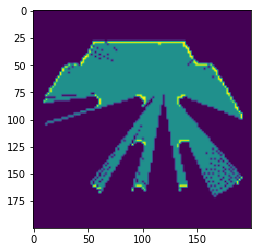

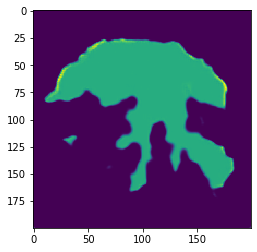

tensor(0.3332)
tensor([0.3332], device='cuda:0')


In [12]:
# validate map encoder and decoder
sub_dir_name = get_first_episode_log_dir(log_dir)
index = 0

row_map = np.load(log_dir + sub_dir_name + "/maps.npy")[index]
map = mapAutoencoder.transform_map(row_map).squeeze()
plt.imshow(map)
plt.show()
with torch.no_grad():
    plt.imshow(map_autoencoder.decoder(get_encoded_maps_and_ratio_of_episode(sub_dir_name, log_dir)[0][index]).squeeze().cpu())
    plt.show()

print((map > 0).sum() / (map > -100).sum())
print(get_encoded_maps_and_ratio_of_episode(sub_dir_name, log_dir)[1][index])

In [13]:
weight_path = weight_dir + sorted([w for w in os.listdir(weight_dir) if "scan_autoencoder" in w])[-1]

scan_autoencoder = scanAutoencoder.Autoencoder().to(device)
scan_autoencoder.load_state_dict(torch.load(weight_path))


def get_min_and_encoded_scans_of_episode(sub_dir_name, log_dir):
    scans = np.load(log_dir + sub_dir_name + "/scans.npy")
    scans_shape = scans.shape
    min_distance = torch.Tensor(scans.min(axis=-1).reshape(scans_shape[0], scans_shape[1], 1)).to(device)
    scans = torch.stack([scanAutoencoder.transform_scan(s) for s in scans]).to(device)
    with torch.no_grad():
        scans = scan_autoencoder.encoder(scans).reshape(scans_shape[0], scans_shape[1], 32)
    return min_distance, scans

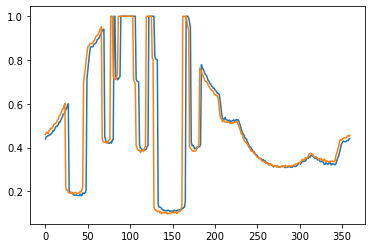

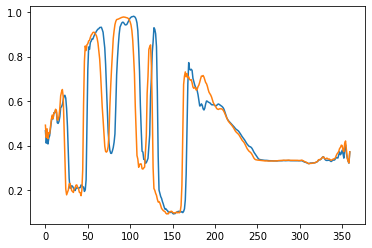

In [14]:
# validate scan encoder and decoder
sub_dir_name = get_first_episode_log_dir(log_dir)

scans = np.load(log_dir + sub_dir_name + "/scans.npy")[0]
scans = scanAutoencoder.transform_scan(scans).reshape(5, 360)

plt.plot(scans[0])
plt.plot(scans[1])
plt.show()
with torch.no_grad():
    plt.plot(scan_autoencoder.decoder(get_min_and_encoded_scans_of_episode(sub_dir_name, log_dir)[1][0, 0]).squeeze().cpu())
    plt.plot(scan_autoencoder.decoder(get_min_and_encoded_scans_of_episode(sub_dir_name, log_dir)[1][0, 1]).squeeze().cpu())
    plt.show()


In [15]:
def get_rotations_of_episode(sub_dir_name, log_dir):
    return torch.Tensor(np.load(log_dir + "/" + sub_dir_name + "/rotations.npy")).to(device)

In [16]:
def get_velocities_of_episode(sub_dir_name, log_dir):
    return torch.Tensor(np.load(log_dir + "/" + sub_dir_name + "/velocities.npy")).to(device)

In [17]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [18]:
memory = ReplayMemory(1000)

In [19]:
NUMBER_OF_ACTIONS = 9

In [20]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(418, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, NUMBER_OF_ACTIONS),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [21]:
dqn = DQN().to(device)

In [22]:
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

In [23]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)

In [26]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        print("not enough data")
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    with torch.no_grad():
        next_state_values = reward_batch + (GAMMA * target_net(next_state_batch).max(1).values.reshape(-1, 1))

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, next_state_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


optimize_model()

not enough data


In [27]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [28]:

reward1_list = []
reward2_list = []
reward3_list = []

reward_list = []

637

In [ ]:
num_episodes = 50

for i_episode in range(num_episodes):
    sub_dir_name = get_first_episode_log_dir(log_dir)
    while not sub_dir_name:
        print("there is no log dir")
        time.sleep(20)
        sub_dir_name = get_first_episode_log_dir(log_dir)
    
        
    encoded_maps, map_ratioes = get_encoded_maps_and_ratio_of_episode(sub_dir_name, log_dir)
    scan_min_distances, encoded_scans = get_min_and_encoded_scans_of_episode(sub_dir_name, log_dir)
    rotations = get_rotations_of_episode(sub_dir_name, log_dir)
    velocities = get_velocities_of_episode(sub_dir_name, log_dir)

    assert(encoded_maps.shape[0] == scan_min_distances.shape[0])
    assert(encoded_maps.shape[0] == encoded_scans.shape[0])
    assert(encoded_maps.shape[0] == rotations.shape[0])
    assert(encoded_maps.shape[0] == velocities.shape[0])
    assert(encoded_scans.shape[1] == 5)

    # N + 1 state
    states = torch.concatenate([encoded_maps, encoded_scans.reshape(-1, 5*32), rotations, velocities], axis=1)


    # N reward
    reward1 = (velocities / 0.3)[1:] # velocity reward: 0 => 0   0.15 => 0.5   0.30 => 1.0
    # reward2 = (scan_min_distances[1:].min(axis=1).values < COLLISION_DISTANCE) * -10 # colision => -10
    x = scan_min_distances[1:].min(axis=1).values
    reward2 = 2 * (x - 0.3) / (x * x)
    reward2[reward2 > 0] = 0

    reward3 = (map_ratioes[1:] - map_ratioes[:-1]) * 500

    reward = reward1 + reward2 + reward3

    # N action
    action = (((velocities / 0.15) * 3) + ((rotations / 0.3) + 1))[1:]

    for i in range(reward.shape[0]):
        memory.push(
            states[i].reshape(1, -1),
            action[i].reshape(1, 1).to(torch.long),
            states[i+1].reshape(1, -1),
            reward[i].reshape(1, 1)
        )

        for _ in range(100):
            optimize_model()

    reward1_list.append(reward1.sum().item())
    reward2_list.append(reward2.sum().item())
    reward3_list.append(reward3.sum().item())
    reward_list.append(reward.sum().item())

    # shutil.rmtree(log_dir + "/" + sub_dir_name)
    shutil.move(log_dir + "/" + sub_dir_name, log_dir2)

    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)


    if (i_episode + 1) % 10 == 0:
        torch.save(target_net.state_dict(), weight_dir + "dqn_weight " + str(datetime.datetime.now())[:19])
        print("reward1: move forward")
        plt.plot(reward1_list)
        plt.plot(movingaverage(reward1_list, 15))
        plt.show()

        print("reward2: obtacle")
        plt.plot(reward2_list)
        plt.plot(movingaverage(reward2_list, 15))
        plt.show()

        print("reward3: map construction")
        plt.plot(reward3_list)
        plt.plot(movingaverage(reward3_list, 15))
        plt.show()

        print("total reward:")
        plt.plot(reward_list)
        plt.plot(movingaverage(reward_list, 15))
        plt.show()

In [42]:
len(reward1_list)

750

reward1: move forward


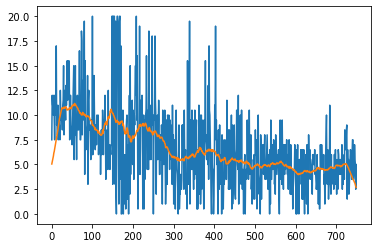

reward2: obstacle


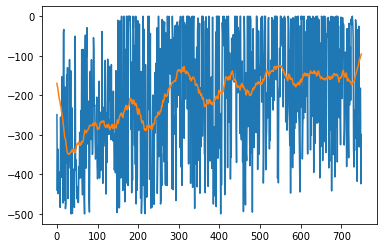

reward3: map construction


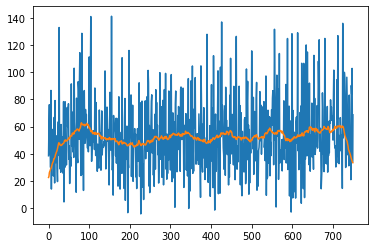

total reward:


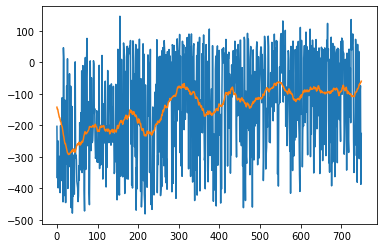

In [44]:
print("reward1: move forward")
plt.plot(reward1_list)
plt.plot(movingaverage(reward1_list, 50))
plt.show()

print("reward2: obstacle")
plt.plot(reward2_list)
plt.plot(movingaverage(reward2_list, 50))
plt.show()

print("reward3: map construction")
plt.plot(reward3_list)
plt.plot(movingaverage(reward3_list, 50))
plt.show()

print("total reward:")
plt.plot(reward_list)
plt.plot(movingaverage(reward_list, 50))
plt.show()